# Feature Detection and Extraction

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-9/embed" width="100%" height="500" title="Test Title" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

In this chapter, we move from **depth estimation** to one of the core tasks in classical computer vision: **finding good feature points**.

---

## Why are features important?

When we work with multiple images (matching, tracking, depth), we rely on points that are:
- **Repeatable**: they appear reliably under viewpoint and lighting changes.
- **Distinctive**: they can be matched unambiguously.
- **Well-localized**: they can be found precisely in pixel space.

**Corners** are a classic example of such features.

## What is a Good Corner?

A good corner is a point where the image intensity changes sharply in **multiple directions**.

- In a **flat region**, shifting a window does not change intensity → no feature.
- Along an **edge**, shifting **along** the edge does not change intensity → ambiguous.
- At a **corner**, shifting in any direction causes a significant change → repeatable and well-localized.

---

The **Harris Corner Detector** formalizes this intuition mathematically.

## Harris Corner Detector: Theory

The Harris corner detector works by measuring how much the image changes when a window is shifted in different directions.

Mathematically, the change in image intensity $E(u, v)$ for a small shift $(u, v)$ is:

$$
E(u, v) = \sum_{x, y} w(x, y) [I(x + u, y + v) - I(x, y)]^2
$$

where:
- $I(x, y)$ is the image intensity.
- $w(x, y)$ is a window function (typically a square or Gaussian window).

Using a first-order Taylor expansion:

$$
I(x + u, y + v) \approx I(x, y) + I_x u + I_y v
$$

where $I_x$ and $I_y$ are image gradients.

So,

$$
E(u, v) \approx 
\begin{bmatrix} u & v \end{bmatrix}
M
\begin{bmatrix} u \\ v \end{bmatrix}
\quad \text{where} \quad
M = \sum_{x, y} w(x, y)
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}.
$$

$M$ is called the **structure tensor**.

The **eigenvalues** of $M$ tell us:
- Both large → corner.
- One large, one small → edge.
- Both small → flat region.

Harris defined a **corner response function**:

$$
R = \det(M) - k \cdot (\text{trace}(M))^2,
\quad k \in [0.04, 0.06].
$$

Large $R$ → likely corner.

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imageio.v3 as iio
from io import BytesIO

# --- Online functions ---
async def read_image_online(url: str) -> np.ndarray:
    from pyodide.http import pyfetch
    resp = await pyfetch(url=url, method="GET")
    data = BytesIO(await resp.bytes())
    return iio.imread(data, index=None)

async def load_and_show_online(url):
    img = await read_image_online(url)
    if img.ndim == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title("Example Image")
    plt.axis('off')
    plt.show()
    return img

# --- Offline functions ---
def read_image_offline(url: str) -> np.ndarray:
    return iio.imread(url, index=None)

def load_and_show_offline(url):
    img = read_image_offline(url)
    if img.ndim == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title("Example Image")
    plt.axis('off')
    plt.show()
    return img

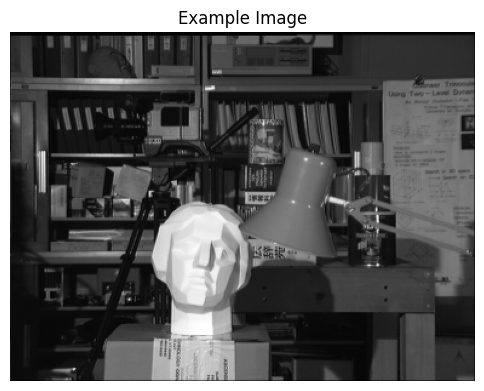

In [ ]:
# Online toggle and input
online = True

LEFT = "https://raw.githubusercontent.com/canberkgurel/DisparityMapfromStereoPair/master/tsukuba_l.png"

if online:
    img = await load_and_show_online(LEFT)
else:
    img = load_and_show_offline(LEFT)

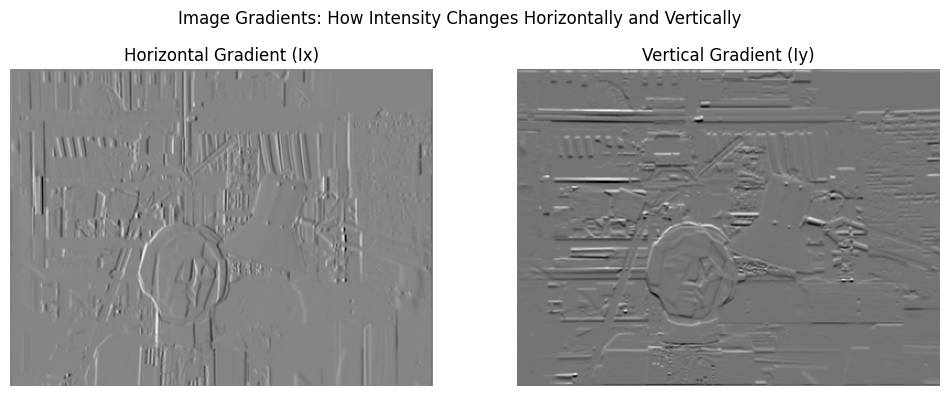

In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def compute_image_gradients(img: np.ndarray):
    """
    Compute x and y image gradients using Sobel operators.
    """
    Ix = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    Iy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    return Ix, Iy

Ix, Iy = compute_image_gradients(img)

plt.figure(figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plt.imshow(Ix, cmap='gray')
plt.title('Horizontal Gradient (Ix)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Iy, cmap='gray')
plt.title('Vertical Gradient (Iy)')
plt.axis('off')

plt.suptitle("Image Gradients: How Intensity Changes Horizontally and Vertically")
plt.show()

## What Do We See in the Gradient Images?

- The **horizontal gradient (Ix)** shows where intensity changes left-to-right.
- The **vertical gradient (Iy)** shows where intensity changes top-to-bottom.

**Edges** appear as strong lines in these gradient maps.  
Together, these gradients feed into the **structure tensor** for each pixel.

## Structure Tensor

Next, we compute the **second moment matrix** $M$ for each pixel using the gradients.

We apply a **window function** — in practice, we use a **Gaussian** or **box filter** to smooth the squared gradients.

$$
M = 
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix} * w.
$$

This step tells us how much variation there is in the local neighborhood.

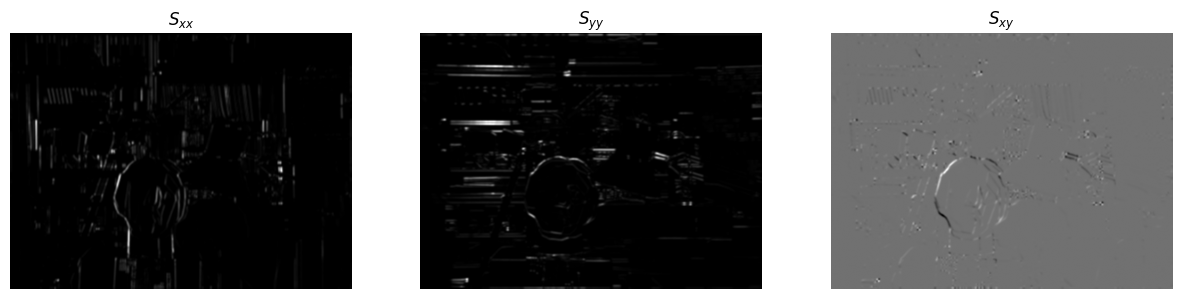

In [6]:
def compute_structure_tensor(Ix, Iy, window_size=3):
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    Sxx = cv.GaussianBlur(Ixx, (window_size, window_size), 0)
    Syy = cv.GaussianBlur(Iyy, (window_size, window_size), 0)
    Sxy = cv.GaussianBlur(Ixy, (window_size, window_size), 0)

    return Sxx, Syy, Sxy

Sxx, Syy, Sxy = compute_structure_tensor(Ix, Iy, window_size=3)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(Sxx, cmap='gray')
plt.title('$S_{xx}$')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Syy, cmap='gray')
plt.title('$S_{yy}$')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Sxy, cmap='gray')
plt.title('$S_{xy}$')
plt.axis('off')

plt.show()

**Interpreting $S_{xx}$, $S_{yy}$, $S_{xy}$**

- $S_{xx}$ shows how strong horizontal changes are in the neighborhood.
- $S_{yy}$ shows vertical changes.
- $S_{xy}$ shows how x and y gradients are correlated — important for mixed edges.

Together, they form the **structure tensor $M$**, which we use to decide if a point is a corner.

## Harris Corner Response

Using the smoothed second moment matrix $M$, compute:

$$
R = \det(M) - k \cdot (\text{trace}(M))^2.
$$

A large $R$ means high corner strength.

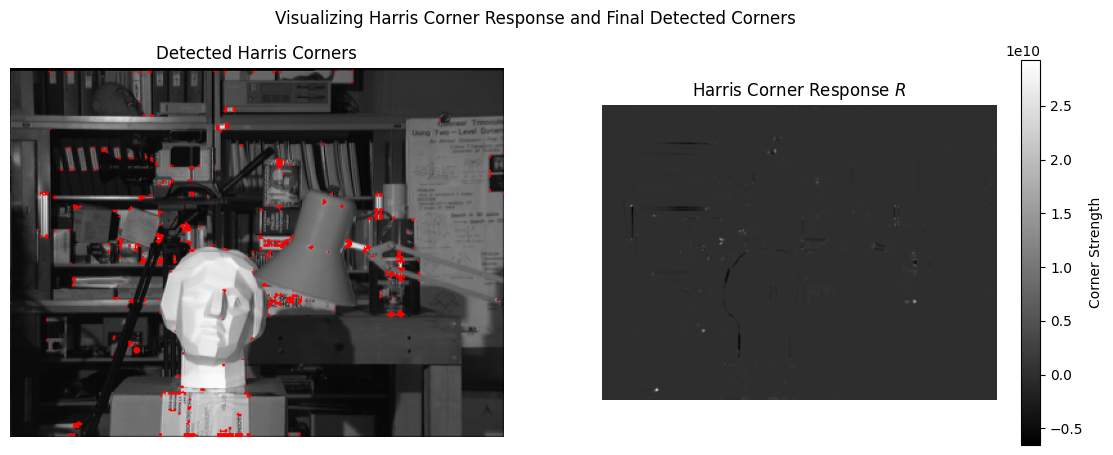

In [19]:
def compute_harris_response(Sxx, Syy, Sxy, k=0.04):
    """
    Compute Harris corner response R for each pixel.
    """
    det = (Sxx * Syy) - (Sxy ** 2)
    trace = Sxx + Syy
    R = det - k * (trace ** 2)
    return R

R = compute_harris_response(Sxx, Syy, Sxy, k=0.04)

def get_harris_corners(R, threshold_ratio=0.01):
    """
    Threshold R to find strong corners.
    """
    R_max = R.max()
    corners = np.zeros_like(R, dtype=np.uint8)
    corners[R > threshold_ratio * R_max] = 255
    return corners

corners = get_harris_corners(R, threshold_ratio=0.01)

# Overlay corners on original image
img_harris = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
img_harris[corners > 0] = [0, 0, 255]  # Red dots

# Plot side by side
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_harris, cv.COLOR_BGR2RGB))
plt.title('Detected Harris Corners')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(R, cmap='gray')
plt.title('Harris Corner Response $R$')
plt.colorbar(label='Corner Strength')
plt.axis('off')

plt.suptitle("Visualizing Harris Corner Response and Final Detected Corners")
plt.show()

## What Does the Harris Response Show?

The heatmap shows **where corners are likely**:
- Bright regions → high $R$ → likely corners.
- Dark regions → flat areas or simple edges.

We now threshold this to extract discrete corner points.

## Harris Corner Detection: What We See

- The final overlay shows detected **corners in red**.
- Notice how they appear at image junctions, corners, and textured spots — just as the theory predicts.
- These are robust to small shifts and rotations but **not scale invariant**.

---

**Key Takeaway:**  
Harris is simple, elegant, and works well for planar corners — but it does not handle changes in scale.

Next, we move to **scale-invariant feature detection** like **SIFT**, which extends this idea for multi-scale matching.

## Local Feature Detection vs. Scale Invariance

We’ve seen that **Harris corners** are great for detecting points with sharp intensity changes — but they are **not scale invariant**.

---

### Why does this matter?

If you shrink or zoom an image:
- The **pixel neighborhood** changes.
- The same corner may **disappear** or appear weaker.
- Harris does not handle this naturally.

---

## How do we handle scale?

Descriptors like **HOG** (Histogram of Oriented Gradients) help:
- They summarize **local gradient orientation patterns**.
- They are more stable across changes in scale and slight rotations.
- They create robust feature vectors for matching.

Original shape: (288, 384)
Scaled-down shape: (144, 192)


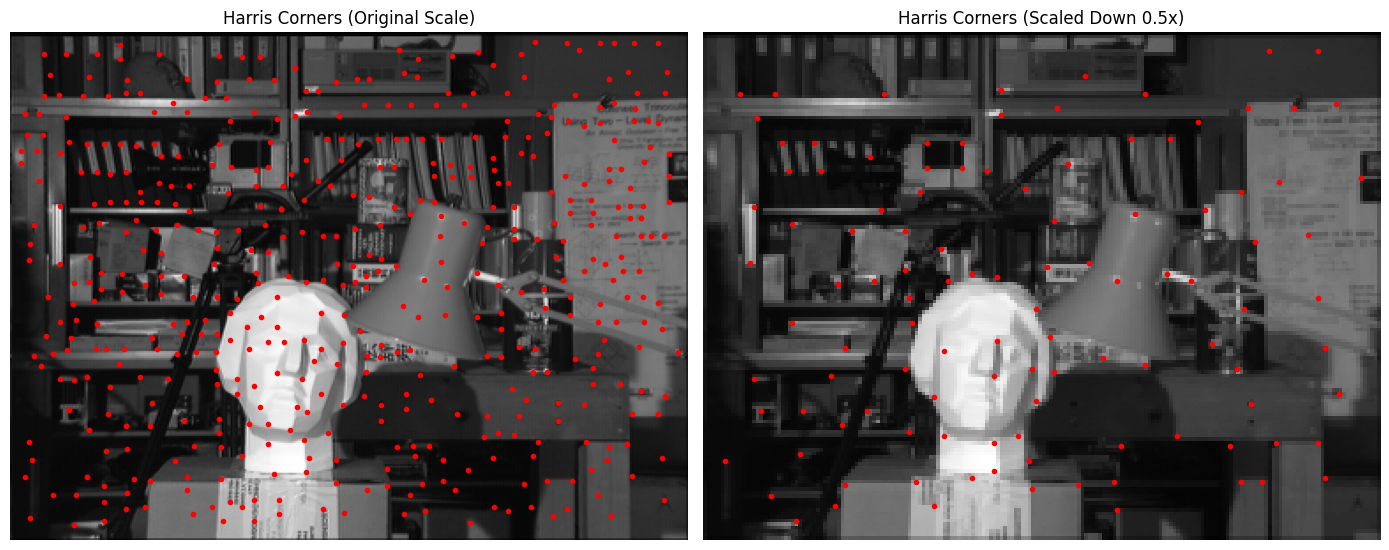

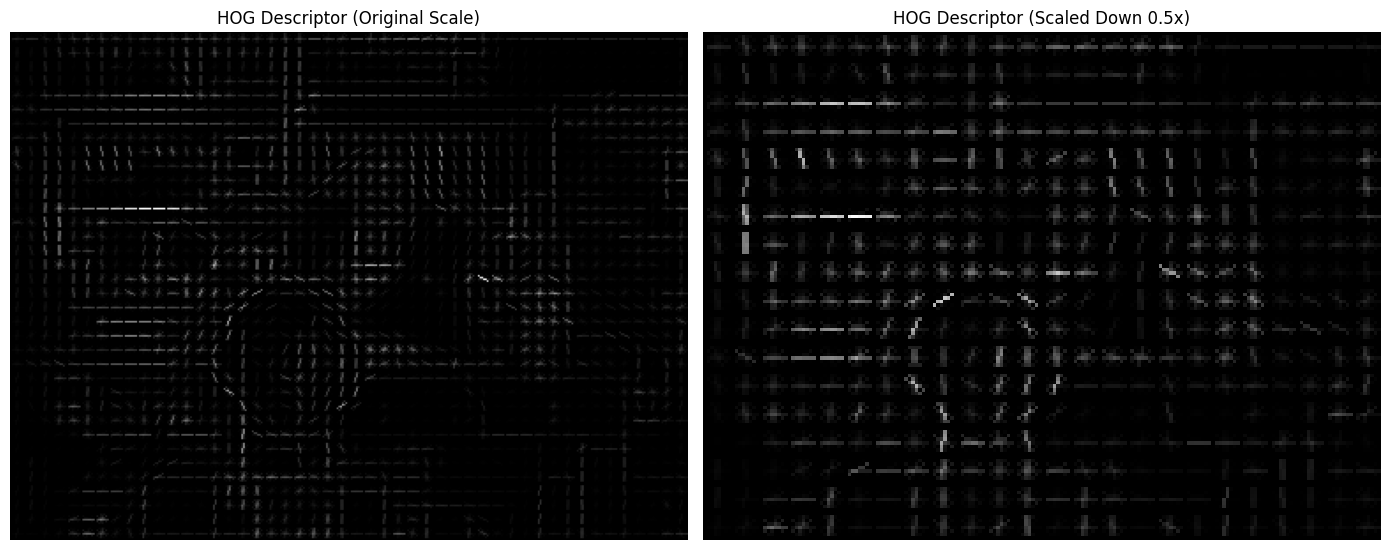

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.feature import corner_harris, corner_peaks, hog
from skimage.util import img_as_float

def analyze_feature_scale_invariance(img_gray: np.ndarray):
    """
    Demonstrate Harris corners vs HOG descriptor behavior under scaling.
    Assumes img_gray is a 2D grayscale float image.
    """

    # Make sure image is float
    img_gray = img_as_float(img_gray)

    # Harris corners at original scale
    harris_orig = corner_harris(img_gray, k=0.05)
    corners_orig = corner_peaks(harris_orig, min_distance=5)

    # Rescale image (0.5x)
    img_small = rescale(img_gray, 0.5, anti_aliasing=True)

    print("Original shape:", img_gray.shape)
    print("Scaled-down shape:", img_small.shape)

    harris_small = corner_harris(img_small, k=0.05)
    corners_small = corner_peaks(harris_small, min_distance=5)

    # Plot Harris results side by side
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].imshow(img_gray, cmap='gray')
    ax[0].plot(corners_orig[:, 1], corners_orig[:, 0], 'ro', markersize=3)
    ax[0].set_title('Harris Corners (Original Scale)')
    ax[0].axis('off')

    ax[1].imshow(img_small, cmap='gray')
    ax[1].plot(corners_small[:, 1], corners_small[:, 0], 'ro', markersize=3)
    ax[1].set_title('Harris Corners (Scaled Down 0.5x)')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

    # HOG descriptor visualization
    _, hog_img_orig = hog(
        img_gray, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys'
    )

    _, hog_img_small = hog(
        img_small, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys'
    )

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].imshow(hog_img_orig, cmap='gray')
    ax[0].set_title("HOG Descriptor (Original Scale)")
    ax[0].axis('off')

    ax[1].imshow(hog_img_small, cmap='gray')
    ax[1].set_title("HOG Descriptor (Scaled Down 0.5x)")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    
analyze_feature_scale_invariance(img)

## What this cell shows:

- **Left:** Harris corners on the original image vs scaled down → you’ll see corners shift or disappear.
- **Right:** HOG descriptors on both scales → local edge patterns remain consistent.

---

**Key Insight:**  
**Scale invariance** is why advanced methods like **SIFT** and **HOG** are so powerful: they maintain the same signature even when the object changes size.